In [1]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load pretrained models
load_pretrained_models = True
# number of epochs of training
n_epochs = 10
# name of the dataset
dataset_path = "/content/input_data"
# size of the batches
batch_size = 16
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 100
# number of cpu threads to use during batch generation
n_cpu = 8
# high res. image height
hr_height = 256
# high res. image width
hr_width = 256
# number of image channels
channels = 3

os.makedirs("output_images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)

### Define Dataset Class

In [3]:
import cv2  # OpenCV for image manipulation
import numpy as np

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def apply_tone_mapping(image, gamma=2.2):
    """Apply gamma correction for tone mapping."""
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

def correct_skew(image):
    """Apply skew correction."""
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    coords = np.column_stack(np.where(gray > 0))
    angle = cv2.minAreaRect(coords)[-1]

    # Adjust the angle
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h, w) = image.size
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    corrected = cv2.warpAffine(np.array(image), M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return Image.fromarray(corrected)

class ImageDataset(Dataset):
    def __init__(self, files, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.files = files

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])

        # Apply skew correction
        img = correct_skew(img)
        # Convert to numpy for tone mapping
        img = np.array(img)
        img = apply_tone_mapping(img)
        img = Image.fromarray(img)

        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)


### Get Train/Test Dataloaders

In [4]:
train_paths, test_paths = train_test_split(sorted(glob.glob(dataset_path + "/*.*")), test_size=0.02, random_state=42)
train_dataloader = DataLoader(ImageDataset(train_paths, hr_shape=hr_shape), batch_size=batch_size, shuffle=True, num_workers=n_cpu)
test_dataloader = DataLoader(ImageDataset(test_paths, hr_shape=hr_shape), batch_size=int(batch_size*0.75), shuffle=True, num_workers=n_cpu)

### Define Model Classes

In [5]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

### Train Super Resolution GAN (SRGAN)

In [6]:
# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

# Load pretrained models
if load_pretrained_models:
    generator.load_state_dict(torch.load("/content/saved_models/generator.pth"))
    discriminator.load_state_dict(torch.load("/content/saved_models/discriminator.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 84.1MB/s]


In [7]:
cuda

True

In [8]:
train_gen_losses, train_disc_losses, train_counter = [], [], []
test_gen_losses, test_disc_losses = [], []
test_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]

for epoch in range(n_epochs):

    ### Training
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.train(); discriminator.train()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        ### Train Generator
        optimizer_G.zero_grad()
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()

        ### Train Discriminator
        optimizer_D.zero_grad()
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        gen_loss += loss_G.item()
        train_gen_losses.append(loss_G.item())
        disc_loss += loss_D.item()
        train_disc_losses.append(loss_D.item())
        train_counter.append(batch_idx*batch_size + imgs_lr.size(0) + epoch*len(train_dataloader.dataset))
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

    # Testing
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.eval(); discriminator.eval()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        ### Eval Generator
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        ### Eval Discriminator
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        gen_loss += loss_G.item()
        disc_loss += loss_D.item()
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

        # Save image grid with upsampled inputs and SRGAN outputs
        if random.uniform(0,1)<0.1:
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_hr, imgs_lr, gen_hr), -1)
            save_image(img_grid, f"output_images/{batch_idx}.png", normalize=False)

    test_gen_losses.append(gen_loss/len(test_dataloader))
    test_disc_losses.append(disc_loss/len(test_dataloader))

    # Save model checkpoints
    if np.argmin(test_gen_losses) == len(test_gen_losses)-1:
        torch.save(generator.state_dict(), "saved_models/generator.pth")
        torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")


Training Epoch 0 :   0%|          | 0/62 [00:00<?, ?it/s]

Testing Epoch 0 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/62 [00:00<?, ?it/s]

Testing Epoch 1 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/62 [00:00<?, ?it/s]

Testing Epoch 2 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 3 :   0%|          | 0/62 [00:00<?, ?it/s]

Testing Epoch 3 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 4 :   0%|          | 0/62 [00:00<?, ?it/s]

Testing Epoch 4 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 5 :   0%|          | 0/62 [00:00<?, ?it/s]

Testing Epoch 5 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 6 :   0%|          | 0/62 [00:00<?, ?it/s]

Testing Epoch 6 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 7 :   0%|          | 0/62 [00:00<?, ?it/s]

Testing Epoch 7 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 8 :   0%|          | 0/62 [00:00<?, ?it/s]

Testing Epoch 8 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 9 :   0%|          | 0/62 [00:00<?, ?it/s]

Testing Epoch 9 :   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_gen_losses, mode='lines', name='Train Generator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_gen_losses, marker_symbol='star-diamond',
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Generator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Generator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial + Content Loss"),
fig.show()

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_disc_losses, mode='lines', name='Train Discriminator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_disc_losses, marker_symbol='star-diamond',
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Discriminator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial Loss"),
fig.show()

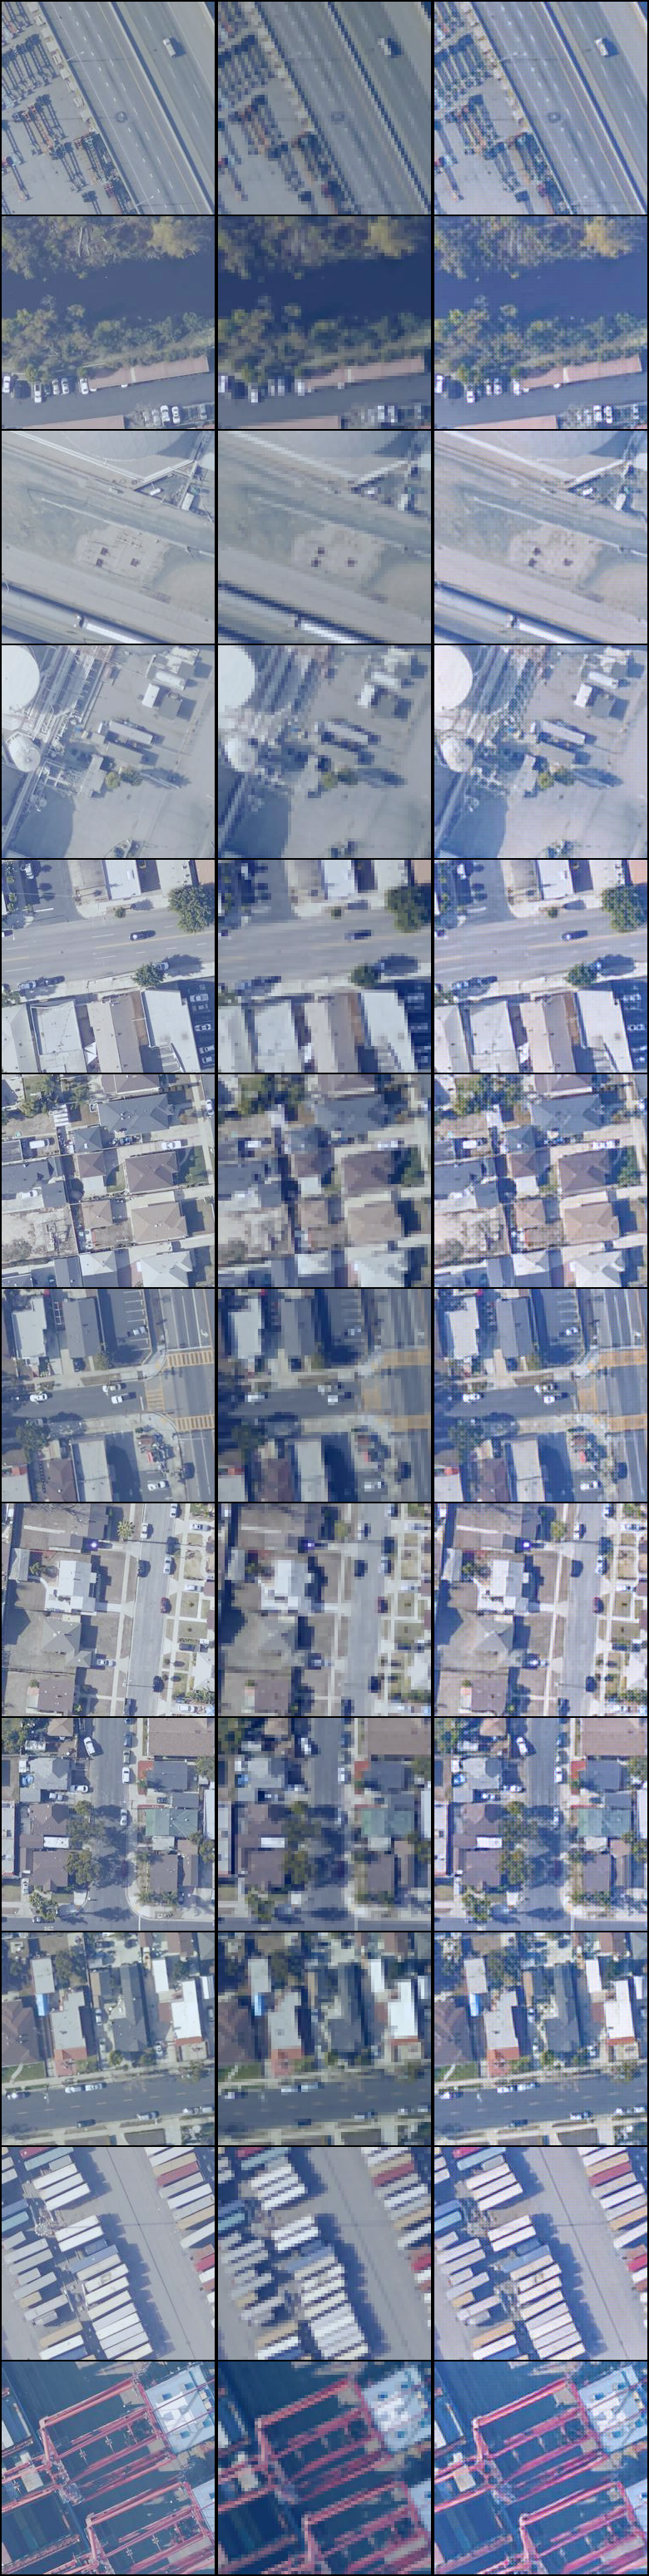

In [11]:
import os
os.listdir("/content/output_images")
from IPython.display import Image, display
display(Image(filename='output_images/0.png'))

# Original High Resolution, Low Resolution & SRGAN Generated

In [12]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
import torch.nn.functional as F

In [13]:
from PIL import Image


In [14]:
import torch

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Your code continues here
import os
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
import torch.nn.functional as F
import plotly.graph_objects as go

# Define metric functions
def calculate_psnr(img1, img2):
    return psnr(img1, img2, data_range=img1.max() - img1.min())

def calculate_ssim(img1, img2):
    return ssim(img1, img2, multichannel=True, data_range=img1.max() - img1.min(), win_size=3)

def calculate_fid(real_features, fake_features):
    mu1, sigma1 = real_features.mean(0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(0), np.cov(fake_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)

# Initialize metric tracking lists
psnr_scores, ssim_scores, inception_scores, fid_scores = [], [], [], []

# Training loop
for epoch in range(n_epochs):
    ### Training loop code here...

    ### Testing and Metrics Calculation
    gen_loss, disc_loss = 0, 0
    psnr_epoch, ssim_epoch, inception_epoch, fid_epoch = [], [], [], []

    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.eval(); discriminator.eval()

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor)).to(device)
        imgs_hr = Variable(imgs["hr"].type(Tensor)).to(device)

        # Generate high resolution images
        gen_hr = generator(imgs_lr)

        # Convert images to numpy for PSNR/SSIM
        imgs_hr_np = imgs_hr.detach().cpu().numpy().transpose(0, 2, 3, 1)
        gen_hr_np = gen_hr.detach().cpu().numpy().transpose(0, 2, 3, 1)

        # PSNR and SSIM
        psnr_batch, ssim_batch = [], []
        for i in range(len(imgs_hr_np)):
            psnr_batch.append(calculate_psnr(imgs_hr_np[i], gen_hr_np[i]))
            ssim_batch.append(calculate_ssim(imgs_hr_np[i], gen_hr_np[i]))
        psnr_epoch.append(np.mean(psnr_batch))
        ssim_epoch.append(np.mean(ssim_batch))

        # Inception Score and FID
        inception = inception_v3(pretrained=True, transform_input=False).eval().to(device)
        inception_score = F.softmax(inception(gen_hr), dim=-1).mean().item()
        inception_epoch.append(inception_score)

        real_features = inception(imgs_hr).detach().cpu().numpy()
        fake_features = inception(gen_hr).detach().cpu().numpy()
        fid_epoch.append(calculate_fid(real_features, fake_features))

    # Append average metrics for the epoch
    psnr_scores.append(np.mean(psnr_epoch))
    ssim_scores.append(np.mean(ssim_epoch))
    inception_scores.append(np.mean(inception_epoch))
    fid_scores.append(np.mean(fid_epoch))

    print(f"Epoch {epoch}: PSNR: {psnr_scores[-1]}, SSIM: {ssim_scores[-1]}, Inception Score: {inception_scores[-1]}, FID: {fid_scores[-1]}")

# Plotting Metrics over Epochs
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(n_epochs)), y=psnr_scores, mode='lines+markers', name='PSNR'))
fig.add_trace(go.Scatter(x=list(range(n_epochs)), y=ssim_scores, mode='lines+markers', name='SSIM'))
fig.update_layout(title="PSNR & SSIM over Epochs", xaxis_title="Epoch", yaxis_title="Score")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(n_epochs)), y=inception_scores, mode='lines+markers', name='Inception Score'))
fig.add_trace(go.Scatter(x=list(range(n_epochs)), y=fid_scores, mode='lines+markers', name='FID Score'))
fig.update_layout(title="Inception Score & FID over Epochs", xaxis_title="Epoch", yaxis_title="Score")
fig.show()


Testing Epoch 0 :   0%|          | 0/2 [00:00<?, ?it/s]

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth

  0%|          | 0.00/104M [00:00<?, ?B/s]
  8%|▊         | 7.88M/104M [00:00<00:01, 82.5MB/s]
 15%|█▌        | 15.8M/104M [00:00<00:01, 80.4MB/s]
 23%|██▎       | 24.0M/104M [00:00<00:01, 70.3MB/s]
 32%|███▏      | 32.9M/104M [00:00<00:00, 78.0MB/s]
 39%|███▉      | 40.6M/104M [00:00<00:00, 78.8MB/s]
 47%|████▋     | 48.4M/104M [00:00<00:00, 78.5MB/s]
 55%|█████▍    | 57.1M/104M [00:00<00:00, 82.1MB/s]
 63%|██████▎   | 65.1M/104M [00:00<00:00, 80.2MB/s]
 70%|███████   | 72.9M/104M [00:00<00:00, 75.3MB/s]
 77%|███████▋  | 80.2M/104M [00:01<00:00, 74.8MB/s]
 84%|████████▍ | 87.8M/104M [00:01<00:00, 75.7MB/s]
 92%|█████████▏| 95.1M/104M [00:01<00:00, 75.9MB/s]
100%|██████████| 104M/104M [00:01<00:00, 76.6MB/s]


Epoch 0: PSNR: 10.253269229857715, SSIM: 0.1689578356565381, Inception Score: 0.0009999999892897904, FID: 1336.748389507256


Testing Epoch 1 :   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: PSNR: 10.288885466711495, SSIM: 0.16827946425298007, Inception Score: 0.0009999999892897904, FID: 1395.2231689491675


Testing Epoch 2 :   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: PSNR: 10.279911489415268, SSIM: 0.17624834717449273, Inception Score: 0.0009999999892897904, FID: 1408.3926795995294


Testing Epoch 3 :   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: PSNR: 10.287608574689484, SSIM: 0.1686436444108082, Inception Score: 0.0009999999892897904, FID: 1421.3925898471273


Testing Epoch 4 :   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: PSNR: 10.304043889018594, SSIM: 0.17197028032412867, Inception Score: 0.0009999999310821295, FID: 1385.1113223882503


Testing Epoch 5 :   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: PSNR: 10.295279776472524, SSIM: 0.17351606829850305, Inception Score: 0.0009999999892897904, FID: 1354.4959880728325


Testing Epoch 6 :   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: PSNR: 10.334405119225732, SSIM: 0.1693067416296371, Inception Score: 0.0009999999892897904, FID: 1390.9057367607486


Testing Epoch 7 :   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: PSNR: 10.326107057408578, SSIM: 0.1661930767985248, Inception Score: 0.0009999999310821295, FID: 1385.349332182323


Testing Epoch 8 :   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: PSNR: 10.308789897038828, SSIM: 0.16621590603774786, Inception Score: 0.0009999999892897904, FID: 1396.9055498138362


Testing Epoch 9 :   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: PSNR: 10.34945079458073, SSIM: 0.16451256232679085, Inception Score: 0.0009999999892897904, FID: 1394.5202330470847


In [15]:
import os
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
import torch.nn.functional as F
import torch
import plotly.graph_objects as go
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image
from tqdm import tqdm

# Assuming the models (Generator, Discriminator, etc.) and dataloaders are already defined

# Define metric functions
def calculate_psnr(img1, img2):
    return psnr(img1, img2, data_range=img1.max() - img1.min())

def calculate_ssim(img1, img2):
    return ssim(img1, img2, multichannel=True, data_range=img1.max() - img1.min(), win_size=3)

def calculate_fid(real_features, fake_features):
    mu1, sigma1 = real_features.mean(0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(0), np.cov(fake_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)

# Initialize metric tracking lists
psnr_scores, ssim_scores, inception_scores, fid_scores = [], [], [], []

# Specify device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Inception model for FID/Inception score calculation
inception = inception_v3(pretrained=True, transform_input=False).eval().to(device)

# Training loop
for epoch in range(n_epochs):
    # Initialize metrics for each epoch
    psnr_epoch, ssim_epoch, inception_epoch, fid_epoch = [], [], [], []

    ### Training loop here...

    ### Testing and Metrics Calculation
    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch}', total=len(test_dataloader))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.eval(); discriminator.eval()

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(torch.FloatTensor)).to(device)
        imgs_hr = Variable(imgs["hr"].type(torch.FloatTensor)).to(device)

        # Generate high resolution images
        gen_hr = generator(imgs_lr)

        # Convert images to numpy for PSNR/SSIM
        imgs_hr_np = imgs_hr.cpu().numpy().transpose(0, 2, 3, 1)
        gen_hr_np = gen_hr.detach().cpu().numpy().transpose(0, 2, 3, 1)

        # PSNR and SSIM
        psnr_batch, ssim_batch = [], []
        for i in range(len(imgs_hr_np)):
            psnr_batch.append(calculate_psnr(imgs_hr_np[i], gen_hr_np[i]))
            ssim_batch.append(calculate_ssim(imgs_hr_np[i], gen_hr_np[i]))
        psnr_epoch.append(np.mean(psnr_batch))
        ssim_epoch.append(np.mean(ssim_batch))

        # Inception Score and FID
        with torch.no_grad():
            real_features = inception(imgs_hr).detach().cpu().numpy()
            fake_features = inception(gen_hr).detach().cpu().numpy()

        inception_score = F.softmax(inception(gen_hr), dim=-1).mean().item()
        inception_epoch.append(inception_score)
        fid_epoch.append(calculate_fid(real_features, fake_features))

    # Append average metrics for the epoch
    psnr_scores.append(np.mean(psnr_epoch))
    ssim_scores.append(np.mean(ssim_epoch))
    inception_scores.append(np.mean(inception_epoch))
    fid_scores.append(np.mean(fid_epoch))

    print(f"Epoch {epoch}: PSNR: {psnr_scores[-1]}, SSIM: {ssim_scores[-1]}, Inception Score: {inception_scores[-1]}, FID: {fid_scores[-1]}")

# Plotting Metrics over Epochs
def plot_metrics(n_epochs, psnr_scores, ssim_scores, inception_scores, fid_scores):
    # PSNR & SSIM Plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(n_epochs)), y=psnr_scores, mode='lines+markers', name='PSNR'))
    fig.add_trace(go.Scatter(x=list(range(n_epochs)), y=ssim_scores, mode='lines+markers', name='SSIM'))
    fig.update_layout(title="PSNR & SSIM over Epochs", xaxis_title="Epoch", yaxis_title="Score")
    fig.show()

    # Inception Score & FID Plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(n_epochs)), y=inception_scores, mode='lines+markers', name='Inception Score'))
    fig.add_trace(go.Scatter(x=list(range(n_epochs)), y=fid_scores, mode='lines+markers', name='FID Score'))
    fig.update_layout(title="Inception Score & FID over Epochs", xaxis_title="Epoch", yaxis_title="Score")
    fig.show()

# Call the function to plot the metrics
plot_metrics(n_epochs, psnr_scores, ssim_scores, inception_scores, fid_scores)

Testing Epoch 0: 100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


Epoch 0: PSNR: 10.377367662534919, SSIM: 0.16283383194880136, Inception Score: 0.0009999999892897904, FID: 1372.5087651296612


Testing Epoch 1: 100%|██████████| 2/2 [00:07<00:00,  3.61s/it]


Epoch 1: PSNR: 10.327341377675129, SSIM: 0.16534775133746688, Inception Score: 0.0010000000474974513, FID: 1365.9464618699087


Testing Epoch 2: 100%|██████████| 2/2 [00:05<00:00,  2.77s/it]


Epoch 2: PSNR: 10.338424847785737, SSIM: 0.1642445988483383, Inception Score: 0.0009999999310821295, FID: 1368.3692778653242


Testing Epoch 3: 100%|██████████| 2/2 [00:05<00:00,  2.65s/it]


Epoch 3: PSNR: 10.247743789798673, SSIM: 0.17399405013863056, Inception Score: 0.0009999999892897904, FID: 1392.3108934631023


Testing Epoch 4: 100%|██████████| 2/2 [00:11<00:00,  5.68s/it]


Epoch 4: PSNR: 10.444878663059185, SSIM: 0.1554497201646095, Inception Score: 0.0009999999892897904, FID: 1374.144242664543


Testing Epoch 5: 100%|██████████| 2/2 [00:05<00:00,  2.64s/it]


Epoch 5: PSNR: 10.283188580835475, SSIM: 0.17372871970831177, Inception Score: 0.0009999999892897904, FID: 1400.9300100708933


Testing Epoch 6: 100%|██████████| 2/2 [00:11<00:00,  5.99s/it]


Epoch 6: PSNR: 10.259703091551746, SSIM: 0.17409757001993753, Inception Score: 0.0009999999310821295, FID: 1336.0814571240599


Testing Epoch 7: 100%|██████████| 2/2 [00:05<00:00,  2.79s/it]


Epoch 7: PSNR: 10.079587498931152, SSIM: 0.1917516874982923, Inception Score: 0.0009999999892897904, FID: 1406.19356903659


Testing Epoch 8: 100%|██████████| 2/2 [00:06<00:00,  3.13s/it]


Epoch 8: PSNR: 10.248393676442824, SSIM: 0.17372545936158967, Inception Score: 0.0009999999892897904, FID: 1412.5198003828061


Testing Epoch 9: 100%|██████████| 2/2 [00:11<00:00,  5.88s/it]

Epoch 9: PSNR: 10.287372260013324, SSIM: 0.1742796527224432, Inception Score: 0.0009999999892897904, FID: 1385.4491396662984
